# Trump's tone to Congress

We're going to reproduce [Trump Sounds a Different Tone in First Address to Congress](https://www.nytimes.com/interactive/2017/02/28/upshot/trump-sounds-different-tone-in-first-address-to-congress.html) from The UpShot.

**Datasource 1:** The [NRC Emotional Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing. 

**Datasource 2:** A database of [Trump speeches](https://github.com/PedramNavid/trump_speeches), one speech per file. There are a lot of GitHub repositories of Trump speeches, but at the time this analysis was performed that was the best.

**Datasource 3:** State of the Union addresses taken from [this repo's data directory](https://github.com/m-aleem/SOTU-Analyzer). I also cheated and pasted Trump's SOTU-y address in.

<p class="reading-options">
  <a class="btn" href="/upshot-trump-emolex/trump-vs-state-of-the-union-addresses">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/upshot-trump-emolex/notebooks/Trump vs State of the Union addresses.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/upshot-trump-emolex/notebooks/Trump vs State of the Union addresses.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt:** NRC Emotional Lexicon - a list of English words and their associations with eight basic emotions and two sentiments


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/upshot-trump-emolex/data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt -P data

## Our target

Here's the graphic we're trying to reproduce:

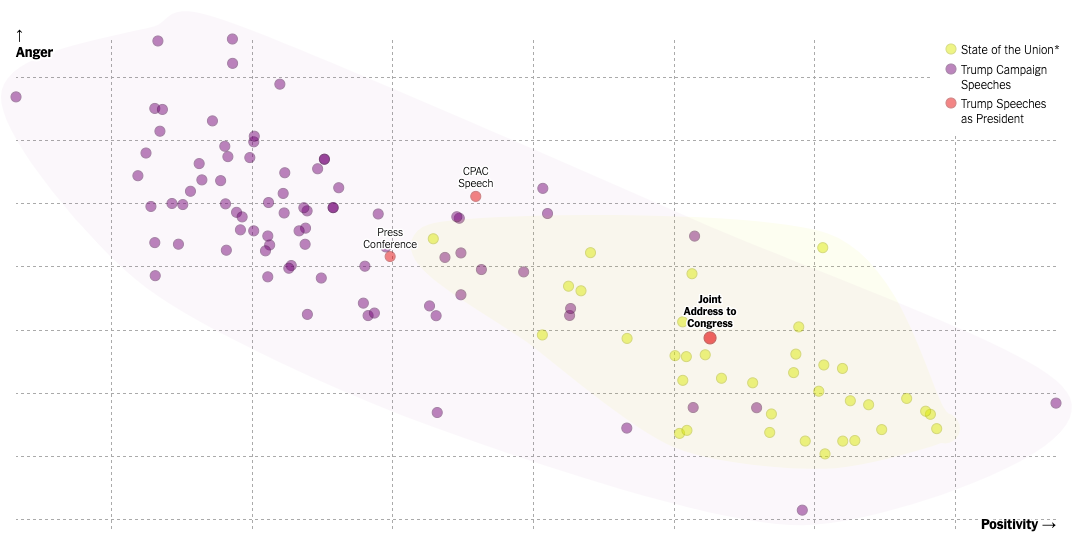

State of the Union addresses in one color, Trump speeches in another. Anger on one axis, positivity on another axis.

**Let's get started!**

In [9]:
import pandas as pd
%matplotlib inline

## Reading in the EmoLex

I'm just copying this from [the intro to the Emotional Lexicon notebook](/upshot-trump-emolex/nrc-emotional-lexicon/)! It's the one at the very bottom that does a lot of reshaping, as I think that layout is the easiest to work with.

In [10]:
filepath = "data/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t', keep_default_na=False)
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


## Reading in Trump's speeches

### Get a list of all of the files

In [1]:
import glob

filenames = glob.glob("data/trump_speeches-master/data/speech*")
filenames[:5]

['data/trump_speeches-master/data/speech_41.txt',
 'data/trump_speeches-master/data/speech_55.txt',
 'data/trump_speeches-master/data/speech_54.txt',
 'data/trump_speeches-master/data/speech_40.txt',
 'data/trump_speeches-master/data/speech_42.txt']

### Read them all in individually

In [2]:
speeches = [open(filename).read() for filename in filenames]
len(speeches)

56

### Create a dataframe out of the results

Instead of passing a list of dictionaries to `pd.DataFrame`, we pass a dictionary that says "here are all of the filenames" and "here are all of the texts" and it puts each list into a column.

In [13]:
speeches_df = pd.DataFrame({
    'text': speeches,
    'filename': filenames
})
speeches_df.head(3)

,text,filename
0,Remarks at the Reno-Sparks Convention Center i...,trump_speeches-master/data/speech_41.txt
1,Remarks in New York City Accepting Election as...,trump_speeches-master/data/speech_55.txt
2,Remarks at the Phoenix Convention Center in Ph...,trump_speeches-master/data/speech_54.txt


### Splitting out the title and content of the speech

The "text" column is formatted with first the title of the speech, then the text. Like this:

In [14]:
speeches_df.loc[0]['text'][:200]

'Remarks at the Reno-Sparks Convention Center in Reno, Nevada\nThank you. I am so thrilled to be here in RenoWith your help, in 34 days, we are going to win this state, we are going to win the White Hou'

We're going to split those out into multiple columns, then delete the original column so we don't get mixed up later.

In [15]:
speeches_df['name'] = speeches_df['text'].apply(lambda value: value.split("\n")[0])
speeches_df['content'] = speeches_df['text'].apply(lambda value: value.split("\n")[1])
del speeches_df['text']
speeches_df.head(2)

,filename,name,content
0,trump_speeches-master/data/speech_41.txt,Remarks at the Reno-Sparks Convention Center i...,Thank you. I am so thrilled to be here in Reno...
1,trump_speeches-master/data/speech_55.txt,Remarks in New York City Accepting Election as...,"Thank you. Thank you very much, everyone. [app..."


## How does Trump sound?

Let's analyze by counting words.

We _could_ use the code below to count all of his words. But **do we really want all of the words?**

```python
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
matrix = vec.fit_transform(speeches_df['content'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()
```

While we could count all the words, remember that the NRC Emotional Lexicon **only includes some words.** It'd kind of be a waste of time to count them all, right?

In [16]:
emolex_df.word.head(3)

0      aback
1     abacus
2    abandon
Name: word, dtype: object

Instead of letting the vectorizer count willy-nilly, we'll feed the vectorizer **just the words in the lexicon**. It's easy-peasy, you just pass `vocabulary=` when you're building your vectorizer.

We're going to use a `TfidfVectorizer` here because we don't care about raw counts - otherwise a longer speech would tend to be angier or more suprised or happier than a shorter one! Instead we're looking for **percentages**. If I say "I hate these onions," we'd count 25% of the words to be negative in there (`hate`, specifically).

To get percentages in our dataframe, we can use a combination of `use_idf=False` and `norm='l1'`.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# I only want you to look for words in the emotional lexicon
# because we don't know what's up with the other words
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False, 
                      norm='l1') # ELL - ONE
matrix = vec.fit_transform(speeches_df.content)
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analysis without the EmoLex

Let's poke around at the results a little bit. We can **sort by one word...**

In [24]:
wordcount_df.sort_values(by='america', ascending=False).head(5)

But since our words are in groups - angry, happy, etc - we'll want to get **a collection at a time.**

In [26]:
wordcount_df[['murder', 'america', 'great', 'prison', 'immigrant']].head(2)

What are some negative words? Let's experiment a little bit.

In [28]:
# bad bad bad = 100% negative
# bad bad evil evil = 50% bad + 50% evil = 100% negative
# bad fish evil fish = 25% bad + 25% evil = 50% negative 
# awful % + hate % + bad % + worse % + evil % = negative %

wordcount_df[['awful', 'hate', 'bad', 'worse', 'evil']].sum(axis=1).head(20)

0     0.003810
1     0.002950
2     0.003401
3     0.001511
4     0.000000
5     0.000000
6     0.000000
7     0.003704
8     0.000000
9     0.001592
10    0.009298
11    0.001658
12    0.002247
13    0.003937
14    0.001802
15    0.014153
16    0.000000
17    0.000000
18    0.006631
19    0.000000
20    0.000000
21    0.004525
22    0.000000
23    0.002008
24    0.001391
25    0.000000
26    0.002066
27    0.004785
28    0.001626
29    0.013943
30    0.000000
31    0.000000
32    0.001873
33    0.001166
34    0.001506
35    0.000000
36    0.005051
37    0.000000
38    0.004367
39    0.000000
40    0.002976
41    0.003871
42    0.007926
43    0.000000
44    0.001709
45    0.000000
46    0.002976
47    0.001812
48    0.002165
49    0.002535
50    0.002430
51    0.005650
52    0.007979
53    0.002304
54    0.007442
55    0.010121
dtype: float64

If we thought those were all of the negative words that existed in the world, we could add them up to get a "percentage of the speech that these words" number, which we could also consider as "percentage of the speech that was negative" number.

In [ ]:
speeches_df['negative'] = wordcount_df[['awful', 'hate', 'bad', 'worse', 'evil']].sum(axis=1)
speeches_df.head(3)

We could do the same thing about **policy** if we had a list of words about policy.

In [30]:
speeches_df['policy'] = wordcount_df[['crime', 'discrimination', 'poverty', 'border']].sum(axis=1)
speeches_df.head(3)

And then magically enough we can plot them against each other!

In [31]:
speeches_df.plot(x='negative', 
                 y='policy', 
                 kind='scatter',
                 ylim=(0,0.01),
                 xlim=(0,0.005))

## Adding in the EmoLex

Instead of a list of semi-random words, we'll use the NRC Emotional Lexicon instead.

In [32]:
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


What words are angry?

In [33]:
emolex_df[emolex_df.anger == 1].head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0
17,abhor,1,0,1,1,0,1,0,0,0,0
18,abhorrent,1,0,1,1,0,1,0,0,0,0
27,abolish,1,0,0,0,0,1,0,0,0,0


We don't need all those columns, right? We just need **the words themselves.**

In [34]:
# Get your list of angry words
angry_words = emolex_df[emolex_df.anger == 1]['word']
angry_words.head()

3       abandoned
4     abandonment
17          abhor
18      abhorrent
27        abolish
Name: word, dtype: object

Previously we asked the `wordcount_df` for specific words, words that we chose.

```python
wordcount_df[['awful', 'hate', 'bad', 'worse', 'evil']]
```

But what if instead we just... fed it the list of angry words from the emotional lexicon? In the same way we could do `['awful', 'hate', 'bad', 'worse', 'evil']` we could also just feed it the list of `angry_words` from above.

In [35]:
wordcount_df[angry_words].head()

,abandoned,abandonment,abhor,abhorrent,abolish,abomination,abuse,accursed,accusation,accused,...,wreck,wrecked,wretch,wring,wrongdoing,wrongful,wrongly,yell,yelp,youth
0,0.0,0.0,0.0,0.0,0.001905,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001905
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001511
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Now we just need to add them up, just like we did with "policy" and "negative" above.

In [36]:
# Only give me the columns of angry words
speeches_df['anger'] = wordcount_df[angry_words].sum(axis=1)
speeches_df.head(3)

,filename,name,content,anger
0,trump_speeches-master/data/speech_41.txt,Remarks at the Reno-Sparks Convention Center i...,Thank you. I am so thrilled to be here in Reno...,0.093333
1,trump_speeches-master/data/speech_55.txt,Remarks in New York City Accepting Election as...,"Thank you. Thank you very much, everyone. [app...",0.017699
2,trump_speeches-master/data/speech_54.txt,Remarks at the Phoenix Convention Center in Ph...,"The silent majority is back. In 10 days, we ar...",0.137755


Let's **repeat that process with positivity**. It's the same process we did with the anger words, but in the convenience of a single cell.

In [38]:
# Get your list of positive words
positive_words = emolex_df[emolex_df.positive == 1].word

# Only give me the columns of angry words
speeches_df['positivity'] = wordcount_df[positive_words].sum(axis=1)
speeches_df.head(3)

,filename,name,content,anger,positivity
0,trump_speeches-master/data/speech_41.txt,Remarks at the Reno-Sparks Convention Center i...,Thank you. I am so thrilled to be here in Reno...,0.093333,0.240000
1,trump_speeches-master/data/speech_55.txt,Remarks in New York City Accepting Election as...,"Thank you. Thank you very much, everyone. [app...",0.017699,0.392330
2,trump_speeches-master/data/speech_54.txt,Remarks at the Phoenix Convention Center in Ph...,"The silent majority is back. In 10 days, we ar...",0.137755,0.209184


## Plot our results

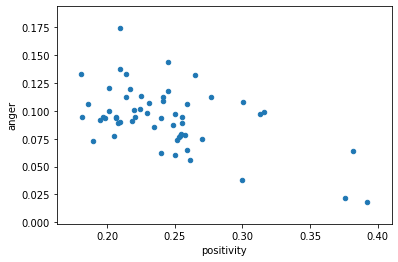

In [39]:
speeches_df.plot(x='positivity', y='anger', kind='scatter')

Okay, looks good so far. But we need to **plot it against State of the Union addresses** to fully reproduce the graphic.

## Reading in the SOTU addresses

Pretty much the same thing as what we did with Trump!

In [40]:
# Get the filenames
# Read them in
# Create a dataframe from the results
filenames = glob.glob("data/SOTU/*.txt")
contents = [open(filename).read() for filename in filenames]
sotu_df = pd.DataFrame({
    'content': contents,
    'filename': filenames
})
sotu_df.head(3)

,content,filename
0,"Thank you very much. Mr. Speaker, Vice Preside...",SOTU/2002.txt
1,"Thank you. Mr. Speaker, Mr. Vice President, Me...",SOTU/2016.txt
2,"Thank you very much. Mr. Speaker, Mr. Vice Pr...",SOTU/2017.txt


### Add a column for the name 

We don't have a name for these, so we'll just use the filename.

In [41]:
sotu_df['name'] = sotu_df['filename']
sotu_df.head()

,content,filename,name
0,"Thank you very much. Mr. Speaker, Vice Preside...",SOTU/2002.txt,SOTU/2002.txt
1,"Thank you. Mr. Speaker, Mr. Vice President, Me...",SOTU/2016.txt,SOTU/2016.txt
2,"Thank you very much. Mr. Speaker, Mr. Vice Pr...",SOTU/2017.txt,SOTU/2017.txt
3,"Mr. Speaker, Vice President Cheney, Members of...",SOTU/2003.txt,SOTU/2003.txt
4,Gentlemen of the Congress:\n\nIn pursuance of ...,SOTU/1913.txt,SOTU/1913.txt


## How do State of the Unions sound?

Let's analyze by counting words. Same thing we did with Trump - set the vocabulary, `use_idf=False` and `norm='l1`.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# I only want you to look for words in the emotional lexicon
# because we don't know what's up with the other words
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False, 
                      norm='l1') # ELL - ONE
matrix = vec.fit_transform(sotu_df['content'])
vocab = vec.get_feature_names()
sotu_wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
sotu_wordcount_df.head()

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000739,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sum up anger and positivity

Then we'll reach into the NRC Emotional Lexicon and total up the positivity and anger.

In [43]:
# Get your list of positive words
positive_words = emolex_df[emolex_df.positive == 1]['word']

# Only give me the columns of angry words
sotu_df['positivity'] = sotu_wordcount_df[positive_words].sum(axis=1)
sotu_df.head(3)

,content,filename,name,positivity
0,"Thank you very much. Mr. Speaker, Vice Preside...",SOTU/2002.txt,SOTU/2002.txt,0.298395
1,"Thank you. Mr. Speaker, Mr. Vice President, Me...",SOTU/2016.txt,SOTU/2016.txt,0.274342
2,"Thank you very much. Mr. Speaker, Mr. Vice Pr...",SOTU/2017.txt,SOTU/2017.txt,0.345898


In [44]:
# Get your list of positive words
angry_words = emolex_df[emolex_df.anger == 1].word

# Only give me the columns of angry words
sotu_df['anger'] = sotu_wordcount_df[angry_words].sum(axis=1)
sotu_df.head(3)

,content,filename,name,positivity,anger
0,"Thank you very much. Mr. Speaker, Vice Preside...",SOTU/2002.txt,SOTU/2002.txt,0.298395,0.079320
1,"Thank you. Mr. Speaker, Mr. Vice President, Me...",SOTU/2016.txt,SOTU/2016.txt,0.274342,0.075000
2,"Thank you very much. Mr. Speaker, Mr. Vice Pr...",SOTU/2017.txt,SOTU/2017.txt,0.345898,0.066519


## Comparing SOTU vs Trump

Now that we have our two datafarmes with positivity and anger, we can plot our graphic!

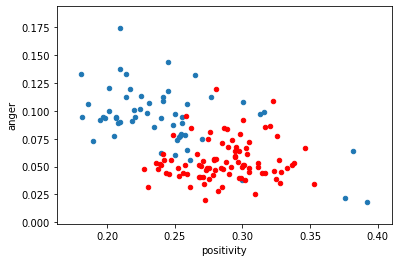

In [45]:
ax = speeches_df.plot(x='positivity', y='anger', kind='scatter')
sotu_df.plot(x='positivity', y='anger', kind='scatter', c='red', ax=ax)


## Review

In this section, we used the **Emotional Lexicon** to compare several sets of political speeches. Instead of just positive and negative sentiment, we were able to graph **anger** compared to **positivity**.

The Emotional Lexicon depends on each individual word having emotional ratings. Our approach was to add up the percentage of words that were each emotion, and use that as our score.

## Discussion topics

To build the NRC Emotional Lexicon, people were asked what emotions individual words had, without _any context at all_. But somehow when you run it against this dataset, the aggregate **seems to make sense.** Does this make us have more faith in individually scoring each word?

To a large degree, this piece reflects many peoples' thoughts that Trump's speeches are negative and angry. If the visual showed them to be more positive and less angry than a normal State of the Union, would we still trust the dataset? Would we still publish this piece? Why or why not?

If the results didn't seem to make sense, would we try again with other emotions on the axes?

Do you think it would work as well with 'anger' vs. 'negative' as opposed to 'anger' vs 'positive'? Try it out and see what you think about the results!